# Pseudo-bulk functional analysis

When cell lineage is clear (there are clear cell identity clusters), it might be beneficial to perform functional analyses at the pseudo-bulk level instead of the single-cell.
By doing so, we recover lowly expressed genes that before where affected by the "drop-out" effect of single-cell. 
Additionaly, if there is more than one condition in our data, we can perform differential expression analysis (DEA) and use the gene statistics as input for enrichment analysis.

In this notebook we showcase how to use `decoupler` for pathway and transcription factor (TF) enrichment from a human data-set. The data consists of ~5k Blood myeloid cells from healthy and COVID-19 infected patients available in the Single Cell Expression Atlas [here](https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-9221/results?plotType=umap&plotOption=20).

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
# Download data-set 
adata = sc.datasets.ebi_expression_atlas("E-MTAB-9221", filter_boring=True)

# Rename meta-data
columns = ['Sample Characteristic[sex]',
           'Sample Characteristic[individual]',
           'Sample Characteristic[disease]',
           'Factor Value[inferred cell type - ontology labels]']
adata.obs = adata.obs[columns]
adata.obs.columns = ['sex','individual','disease','cell_type']
adata

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'sex', 'individual', 'disease', 'cell_type'

## Processing

This specific data-set contains ensmbl gene ids instead of gene symbols. 
To be able to use `decoupler` we need to transform them into gene symbols:

In [3]:
# Retrieve gene symbols
annot = sc.queries.biomart_annotations("hsapiens",
        ["ensembl_gene_id", "external_gene_name"],
        use_cache=False
    ).set_index("ensembl_gene_id")

# Filter genes not in annotation
adata = adata[:, adata.var.index.intersection(annot.index)]

# Assign gene symbols
adata.var['gene_symbol'] = [annot.loc[ensembl_id,'external_gene_name'] for ensembl_id in adata.var.index]
adata.var = adata.var.reset_index().rename(columns={'index': 'ensembl_gene_id'}).set_index('gene_symbol')

# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

# Remove duplicates
adata.var_names_make_unique()

/var/folders/vl/1y1qg3c911x2hvqbsl7zfpz40000gn/T/ipykernel_8723/3588509663.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_symbol'] = [annot.loc[ensembl_id,'external_gene_name'] for ensembl_id in adata.var.index]
/Users/demian/mambaforge/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Since the meta-data of this data-set is available, we can filter cells that were not annotated:

In [4]:
# Remove non-annotated cells
adata = adata[~adata.obs['cell_type'].isnull()]

We will store the raw counts in the `.layers` attribute so that we can use them
afterwards to generate pseudo-bulk profiles.

In [5]:
# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['normalized'] = adata.X

We can also look how cells cluster by cell identity:

/Users/demian/mambaforge/envs/scanpy/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/demian/mambaforge/envs/scanpy/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/demian/mambaforge/envs/scanpy/lib/python3.11/site-packages/

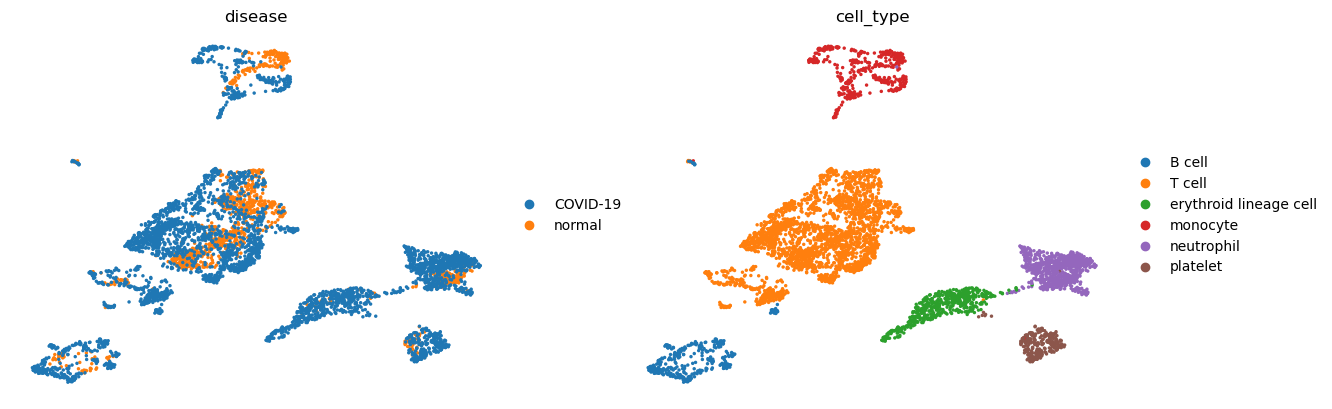

In [6]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, batch_key='individual')

# Scale the data
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

# Generate UMAP features
sc.tl.umap(adata)

# Visualize
sc.pl.umap(adata, color=['disease','cell_type'], frameon=False)

In this data-set we have two condition, `COVID-19` and `healthy`, across 6 different cell types.

## Generation of pseudo-bulk profiles

After the annotation of clusters into cell identities, we often would like to perform differential expression analysis (DEA) between conditions within particular cell types to further characterize them. DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample. We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results. 

The current best practice to correct for this is using a pseudo-bulk approach ([Squair J.W., et al 2021](https://doi.org/10.1038/s41467-021-25960-2)), which involves the following steps:

1. Subsetting the cell type(s) of interest to perform DEA.
2. Extracting their raw integer counts.
3. Summing their counts per gene into a single profile if they pass quality control.
4. Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).

We can pseudobulk using the function `decoupler.get_pseudobulk`. In this example, we are interested in summing the counts but other
modes are available, for more information check its argument `mode`.

In [7]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata

AnnData object with n_obs × n_vars = 39 × 18413
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

It has generated a profile for each sample and cell type. We can plot their quality control metrics:

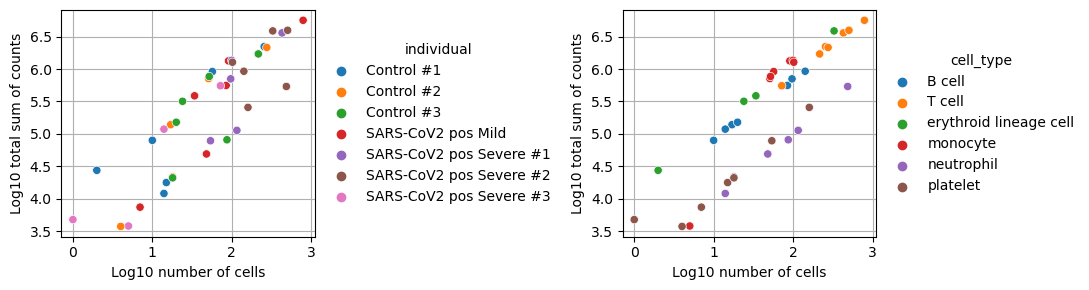

In [8]:
dc.plot_psbulk_samples(pdata, groupby=['individual', 'cell_type'], figsize=(11, 3))

There are two criteria to filter low quality samples: its number of cells (`psbulk_n_cells`), and its total sum of counts (`psbulk_counts`).
In these plots it can be seen that there are some samples of platelet cells that contain less than 10 cells, we might want to remove
them by using the arguments `min_cells` and `min_counts`. Note that these thresholds are arbitrary and will change depening on the
dataset, but a good rule of thumb is to have at least 10 cells with 1000 accumulated counts.

In [9]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='individual',
    groups_col='cell_type',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 34 × 18413
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

### Exploration of pseudobulk profiles
Now that we have generated the pseudobulk profiles for each patient and each cell type, let's explore the variability between them. For that, we will first do some simple preprocessing and then do a PCA

In [10]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6) #library size normalisation
sc.pp.log1p(pp_pdata) # log(1+p) transformation
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)

/Users/demian/mambaforge/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/demian/mambaforge/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


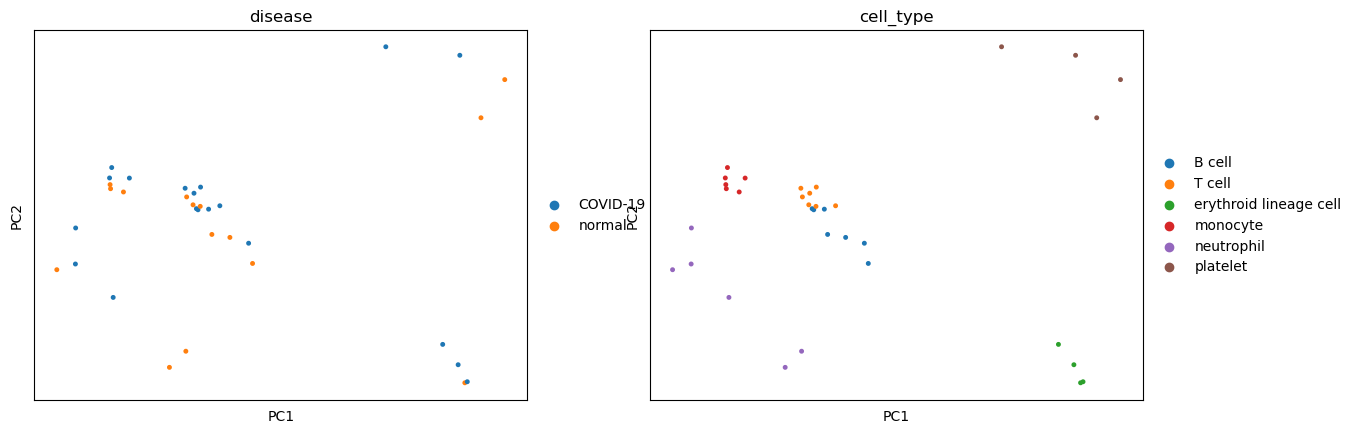

In [11]:
sc.pl.pca(pp_pdata, color=['disease', 'cell_type'], ncols=2, show=True, size=50)

When looking at the PCA, it seems like the two first components are able to easily separate cell types from one another, and it is therefore the main source of variability. In contrast, the principle components do not seem to be associated with disease status as such.

In order to have a better overview of the association of PCs with sample metadata, let's perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples

In [12]:
dc.get_metadata_associations(pp_pdata,
                             obs_keys = ['sex', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'], #metadata columns to associate to PCs
                             obsm_key='X_pca', #where the PCs are stored
                             uns_key='pca_anova', #where the results are stored
                             inplace=True)

100%|██████████| 10/10 [00:00<00:00, 45.89it/s]


Starting plotting HeatmapAnnotations


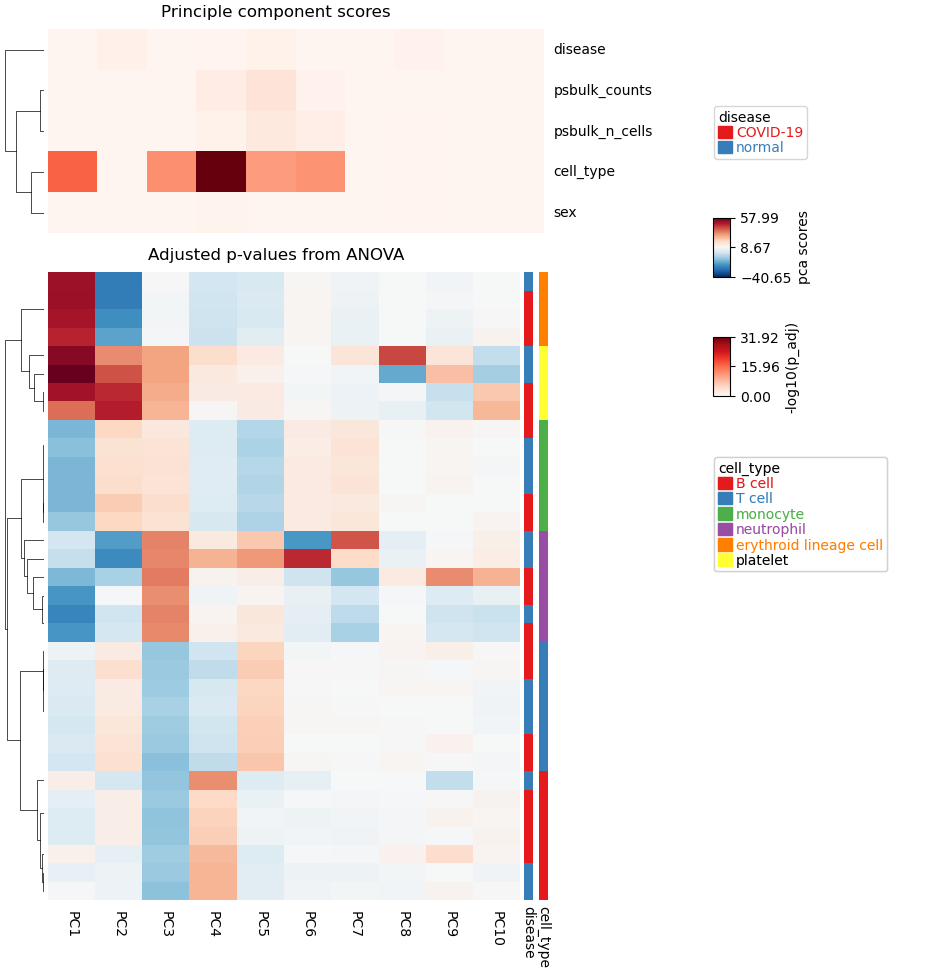

In [13]:
plt.figure(figsize=(7,10))
ax, legend_axes = dc.plot_associations(pp_pdata,
                                       uns_key='pca_anova', #summary statistics from the anova tests
                                       obsm_key='X_pca', #where the PCs are stored
                                       stat_col='p_adj', #which summary statistic to plot
                                       obs_annotation_cols = ['disease', 'cell_type'],
                                       titles=['Adjusted p-values from ANOVA', 'Principle component scores']) # which sample annotations to plot
plt.show()

On the PCA plots above, T and B cells seemed not to be that well separated. However when looking at the hierarchical clustering in the heatmap, one can see that the inclusion of more PCs helps to distinguish them.

When looking at the p-values from the ANOVA models, it becomes clear that the first 6 PCs are statistically associated with the cell type (with the exception of PC2). Overall, disease and other technical variables do not seem to affect the cells when looking only at the principle components.

### Pseudo-bulk profile gene filtering
Additionally to filtering low quality samples, we can also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. Note that this step should be done at the cell type level, since each cell type may express different collection of genes.

For this vignette, we will explore the effects of COVID on T cells. Let's first select our samples of interest:

In [14]:
# Select T cell profiles
tcells = pdata[pdata.obs['cell_type'] == 'T cell'].copy()

To filter genes, we will follow the strategy implemented in the function `filterByExpr` from [edgeR](https://rdrr.io/bioc/edgeR/man/filterByExpr.html).
It keeps genes that have a minimum total number of reads across samples (`min_total_count`), and that have a minimum number of counts in a number of samples (`min_count`).

We can plot how many genes do we keep, you can play with the `min_count` and `min_total_count` to check how many genes would be kept when changed:

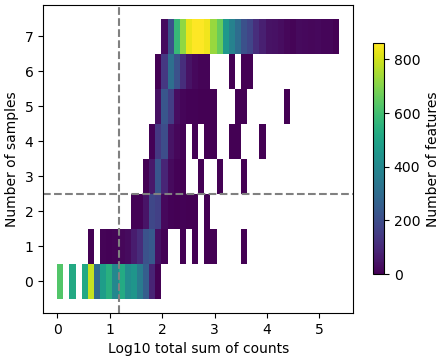

In [15]:
dc.plot_filter_by_expr(tcells, group='disease', min_count=10, min_total_count=15)

Here we can observe the frequency of genes with different total sum of counts and number of samples. The dashed lines indicate the current thresholds, meaning that only the genes in the upper-right corner are going to be kept. Filtering parameters is completely arbitrary, but a good rule of thumb is to identify bimodal distributions and split them modifying the available thresholds.
In this example, with the default values we would keep a good quantity of genes while filtering potential noisy genes.

<div class="alert alert-info">

**Note**
    
Changing the value of `min_count` will drastically change the distribution of "Number of samples", not change its threshold.
In case you want to lower or increase it, you need to play with the `group`, `large_n` and `min_prop` parameters. 


</div>

Once we are content with the threshold parameters, we can perform the actual filtering:

In [16]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(tcells, group='disease', min_count=10, min_total_count=15)

# Filter by these genes
tcells = tcells[:, genes].copy()
tcells

AnnData object with n_obs × n_vars = 7 × 10415
    obs: 'sex', 'individual', 'disease', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    layers: 'psbulk_props'

Another filtering strategy is to filter out genes that are not expressed in a percentage of cells and samples, as implemented
in `decoupler.filter_by_prop`.

## Contrast between conditions
Once we have generated robust pseudo-bulk profiles, we can compute DEA. For this example, we will perform a simple
experimental design where we compare the gene expression of T cells from diseased patients against controls. We will use the
python implementation of the framework DESeq2, but we could have used any other one (`limma` or `edgeR` for example).
For a better understanding how it works, check [DESeq2's documentation](https://pydeseq2.readthedocs.io/en/latest/). Note that
more complex experimental designs can be used by adding more factors to the `design_factors` argument.

In [17]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [18]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=tcells,
    design_factors='disease',
    ref_level=['disease', 'normal'],
    refit_cooks=True,
    n_cpus=8,
)

In [19]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 12.25 seconds.

Fitting dispersion trend curve...
... done in 2.06 seconds.

Fitting MAP dispersions...
... done in 11.53 seconds.

Fitting LFCs...
... done in 1.07 seconds.

Refitting 0 outliers.



In [20]:
# Extract contrast between COVID-19 vs normal
stat_res = DeseqStats(dds, contrast=["disease", 'COVID-19', 'normal'], n_cpus=8)

In [21]:
# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 0.48 seconds.

Log2 fold change & Wald test p-value: disease COVID-19 vs normal


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,70.471695,-0.162066,0.141199,-1.147785,0.251057,0.614273
A2M,36.735027,-1.259564,0.334068,-3.770386,0.000163,0.008154
A2MP1,15.628273,0.651762,1.016771,0.641012,0.521515,0.811402
AAAS,18.305876,0.245218,0.412660,0.594237,0.552353,0.827536
AACS,24.630203,0.216561,0.218214,0.992428,0.320989,0.679457
...,...,...,...,...,...,...
ZXDC,30.181499,-0.306623,0.318297,-0.963324,0.335385,0.692189
ZYG11B,101.884605,0.279126,0.337143,0.827915,0.407719,0.741604
ZYX,81.599907,0.292860,0.202160,1.448655,0.147434,0.485154


In [22]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='disease_COVID-19_vs_normal')

Fitting MAP LFCs...
... done in 2.44 seconds.

Shrunk Log2 fold change & Wald test p-value: disease COVID-19 vs normal


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,70.471695,-0.106885,0.133309,-1.147785,0.251057,0.614273
A2M,36.735027,-1.062147,0.346522,-3.770386,0.000163,0.008154
A2MP1,15.628273,0.019693,0.299477,0.641012,0.521515,0.811402
AAAS,18.305876,0.040897,0.244583,0.594237,0.552353,0.827536
AACS,24.630203,-0.144270,0.454936,0.992428,0.320989,0.679457
...,...,...,...,...,...,...
ZXDC,30.181499,-0.080566,0.225020,-0.963324,0.335385,0.692189
ZYG11B,101.884605,0.065588,0.231517,0.827915,0.407719,0.741604
ZYX,81.599907,0.152862,0.187339,1.448655,0.147434,0.485154


In [23]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,70.471695,-0.106885,0.133309,-1.147785,0.251057,0.614273
A2M,36.735027,-1.062147,0.346522,-3.770386,0.000163,0.008154
A2MP1,15.628273,0.019693,0.299477,0.641012,0.521515,0.811402
AAAS,18.305876,0.040897,0.244583,0.594237,0.552353,0.827536
AACS,24.630203,-0.144270,0.454936,0.992428,0.320989,0.679457
...,...,...,...,...,...,...
ZXDC,30.181499,-0.080566,0.225020,-0.963324,0.335385,0.692189
ZYG11B,101.884605,0.065588,0.231517,0.827915,0.407719,0.741604
ZYX,81.599907,0.152862,0.187339,1.448655,0.147434,0.485154


We can plot the obtained results in a volcano plot:

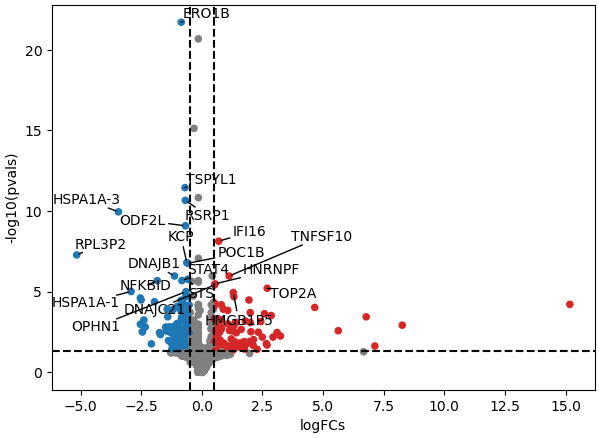

In [24]:
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [25]:
mat = results_df[['stat']].T.rename(index={'stat': 'T cell'})
mat

gene_symbol,A1BG,A2M,A2MP1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUP1,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
T cell,-1.147785,-3.770386,0.641012,0.594237,0.992428,-0.140758,-0.617294,0.295147,1.39611,0.50721,...,1.494477,1.360258,3.547168,-1.018048,-2.253207,-0.963324,0.827915,1.448655,0.122474,-0.248011


## Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

</div> 

In [26]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight
0,MYC,TERT,1
1,SPI1,BGLAP,1
2,SMAD3,JUN,1
3,SMAD4,JUN,1
4,STAT5A,IL2,1
...,...,...,...
43173,NFKB,hsa-miR-143-3p,1
43174,AP1,hsa-miR-206,1
43175,NFKB,hsa-miR-21-5p,1
43176,NFKB,hsa-miR-224-5p,1


### Activity inference with Univariate Linear Model (ULM)

To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

<img src="../ulm.png" />

We can run `ulm` with a one-liner:

In [27]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID3B,ARID4A,ARID5B,ARNT,...,ZNF350,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF91
T cell,0.49035,0.875658,-1.34873,-1.330088,0.505271,-0.36892,-0.309862,0.223921,0.150226,-1.034639,...,-1.533485,2.00729,0.97759,0.39619,-1.447971,1.025928,-0.608226,0.76529,1.985592,-1.948504


Let us plot the obtained scores for the top active/inactive transcription factors:

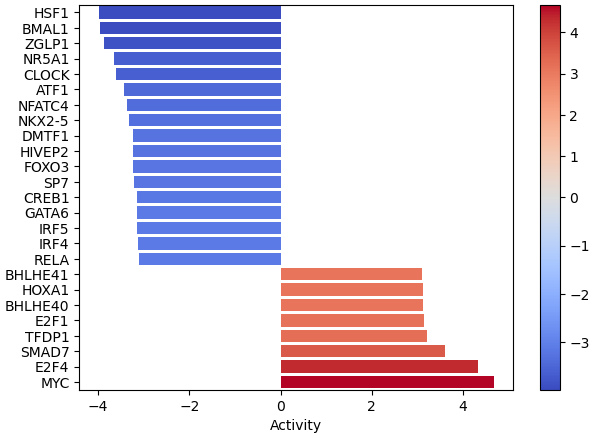

In [28]:
dc.plot_barplot(tf_acts, 'T cell', top=25, vertical=True)

In accordance to the previous pathway results, T cells seem to activate for TFs responsible for cell growth (E2F4, TFDP1, E2F1).

Like with pathways, we can explore how the target genes look like:

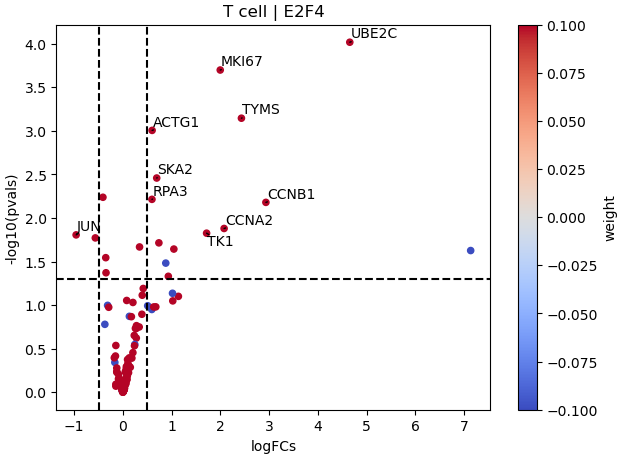

In [29]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'T cell'})
pvals = results_df[['padj']].T.rename(index={'padj': 'T cell'})

# Plot
dc.plot_volcano(logFCs, pvals, 'T cell', name='E2F4', net=collectri, top=10, sign_thr=0.05, lFCs_thr=0.5)

## Pathway activity inference

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [30]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,NME7,-2.504800,1.493383e-06
6996,p53,ZMYM4,-2.325752,1.522388e-06
6997,p53,CFDP1,-1.628168,1.526045e-06
6998,p53,VPS37D,2.309503,1.537098e-06


### Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

<img src="../mlm.png" />
     
We can run `mlm` with a one-liner:

In [31]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
T cell,-0.475637,0.980185,1.627933,-6.009178,8.550902,-0.456872,-5.616791,-0.301604,-2.155228,1.353297,0.497939,0.448216,0.662564,-1.897193


Let us plot the obtained scores:

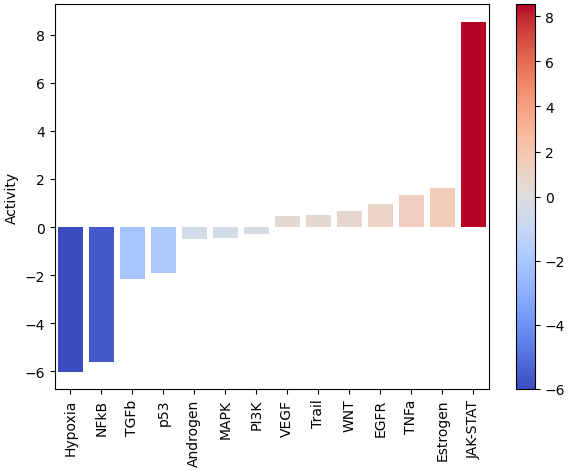

In [32]:
dc.plot_barplot(pathway_acts, 'T cell', top=25, vertical=False)

It looks like JAK-STAT, a known immunity pathway is more active in T cells from COVID-19 patients than in controls. To further explore how the target genes of a pathway of interest behave, we can plot them in scatter plot:

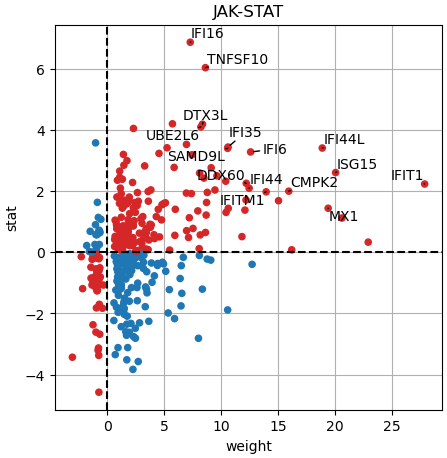

In [33]:
dc.plot_targets(results_df, stat='stat', source_name='JAK-STAT', net=progeny, top=15)

The observed activation of JAK-STAT is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

## Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [34]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


As an example, we will use the hallmark gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [35]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


### Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

<img src="../ora.png" />
     
We can run `ora` with a simple one-liner:

In [36]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.025000,0.529927,0.684847,1.137499,0.722331,ACAA2;MRPL15;NMT1;PPM1B;TALDO1
1,ALLOGRAFT_REJECTION,200,0.030000,0.351911,0.527867,1.347138,1.406920,CSK;FGR;GBP2;PTPN6;STAT4;TNF
2,ANDROGEN_RESPONSE,100,0.020000,0.698206,0.778368,1.030255,0.370109,HERC3;RPS6KA3
3,APICAL_JUNCTION,200,0.010000,0.955563,0.955563,0.513817,0.023355,ACTG1;CERCAM
4,APICAL_SURFACE,44,0.022727,0.658551,0.778368,1.397074,0.583576,ADAM10


Then we can visualize the most enriched terms:

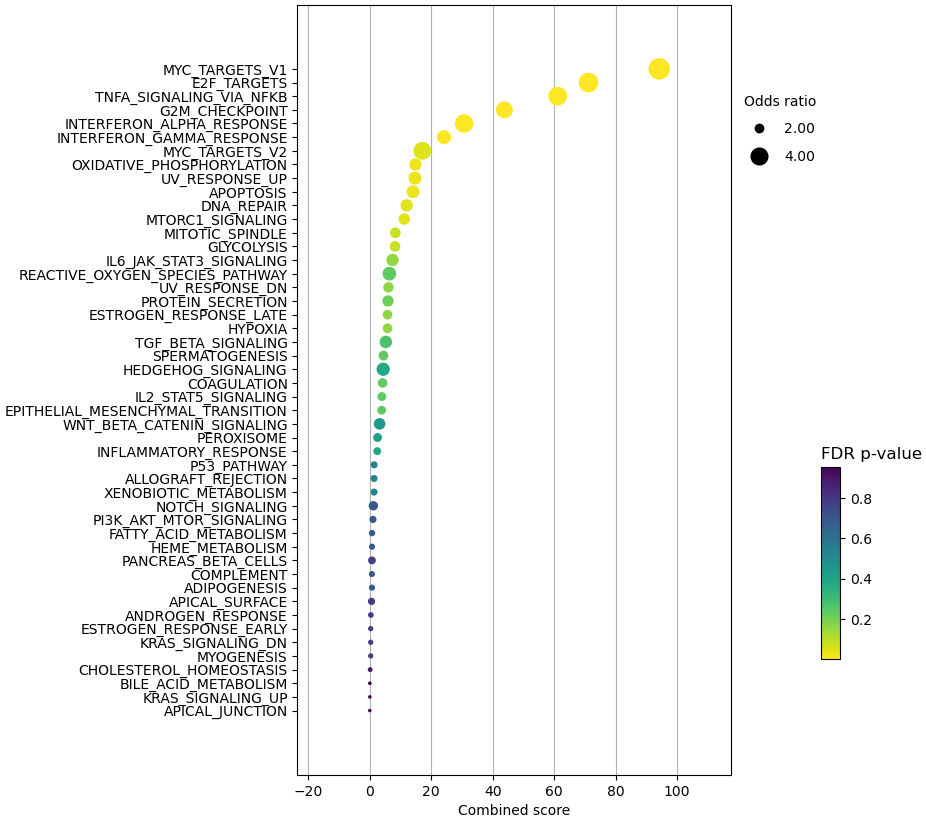

In [37]:
dc.plot_dotplot(enr_pvals, x='Combined score', y = 'Term', s='Odds ratio', c = 'FDR p-value', scale = 0.5, figsize=(7,10))

As before, we can plot the downstream genes of gene sets of interest:

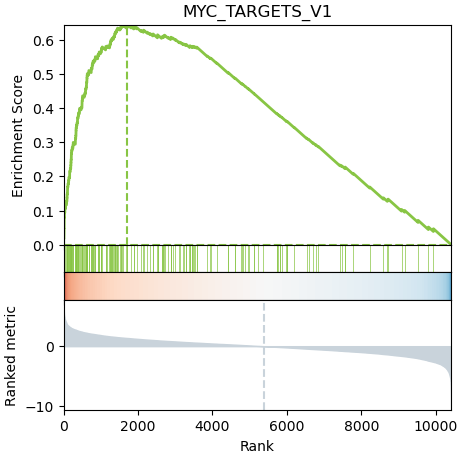

In [38]:
# Plot
dc.plot_running_score(results_df, stat='stat', net=msigdb, source = 'geneset', target='genesymbol', set_name='MYC_TARGETS_V1')